In [1]:
import torch
import yaml
import types
import json

import numpy as np
import matplotlib.patches as patches

import sys
dir = '/home/jjwhit/rcGAN/'
sys.path.append(dir)

from data.lightning.MassMappingDataModule import MMDataModule
from data.lightning.MassMappingDataModule import MMDataTransform
from models.lightning.mmGAN import mmGAN
from mass_map_utils.scripts.ks_utils import backward_model
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import find_contours
import matplotlib.ticker as tkr
from scipy.stats import pearsonr #Correlation function
from skimage.metrics import  peak_signal_noise_ratio as psnr

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def load_object(dct):
    return types.SimpleNamespace(**dct)

In [4]:
torch.set_float32_matmul_precision('medium')

with open(dir+'configs/mass_map.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

dm = MMDataModule(cfg)
fig_count = 1
dm.setup()
test_loader = dm.test_dataloader()

with torch.no_grad():
    mmGAN_model = mmGAN.load_from_checkpoint(
        checkpoint_path='/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_cosmos_new/checkpoint_best.ckpt')

    mmGAN_model.cuda()

    mmGAN_model.eval()

In [5]:
np_gts = {f"{i}": np.load(f"/share/gpu0/jjwhit/samples/np_gts_{i}.npy") for i in range(1, 11)}
np_samps = {f"{i}": np.load(f"/share/gpu0/jjwhit/samples/np_samps_{i}.npy") for i in range(1, 11)}
np_avgs = {f"{i}": np.load(f"/share/gpu0/jjwhit/samples/np_avgs_{i}.npy") for i in range(1, 11)}
np_stds = {f"{i}": np.load(f"/share/gpu0/jjwhit/samples/np_stds_{i}.npy") for i in range(1, 11)}
#array['i'] to access samples; for samples np_samps['i']['j'] where j are the 32 posterior samples.

In [65]:
#Choose which set of samples to plot: (range(1,11))
map = '1'

In [48]:
std1 = np.load(
    cfg.cosmo_dir_path + 'cosmos_std1.npy', allow_pickle=True
)
std2 = np.load(
    cfg.cosmo_dir_path + 'cosmos_std2.npy', allow_pickle=True
)

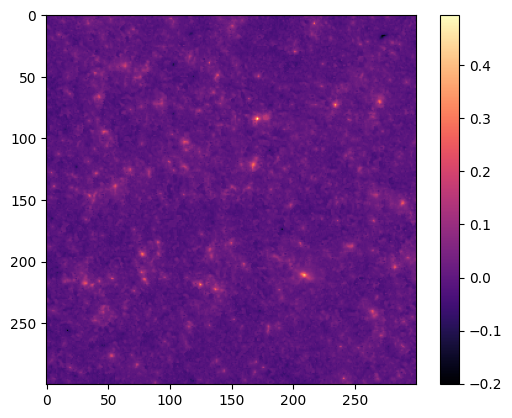

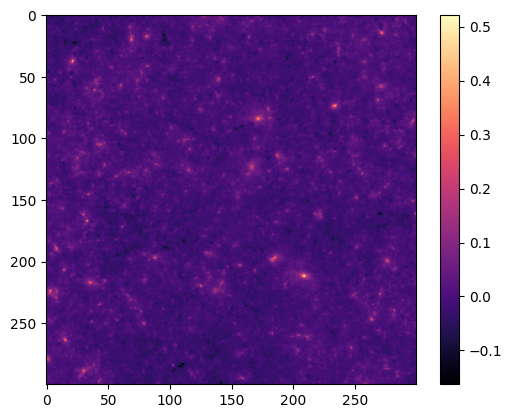

In [6]:
plt.imshow(np_samps[map][30].real,  cmap='magma')
plt.colorbar()
plt.show()
plt.imshow(np_gts[map]s[map].real,  cmap='magma')
plt.colorbar()

In [7]:
method = 'mmGAN'
zoom_length = 80  # Adjust this value based on your preference
margin = 10  # Adjust this value to set the margin

# Ensure the square is not touching the edge
zoom_startx = np.random.randint(margin, cfg.im_size - zoom_length - margin)
zoom_starty1 = np.random.randint(margin, int(cfg.im_size / 2) - zoom_length - margin)
zoom_starty2 = np.random.randint(int(cfg.im_size / 2) + margin, cfg.im_size - zoom_length - margin)

p = np.random.rand()
zoom_starty = zoom_starty1 if p <= 0.5 else zoom_starty2

x_coord = zoom_startx + zoom_length
y_coords = [zoom_starty, zoom_starty + zoom_length]


mask =  np.load(
    cfg.cosmo_dir_path + 'cosmos_mask.npy', allow_pickle=True
).astype(bool)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


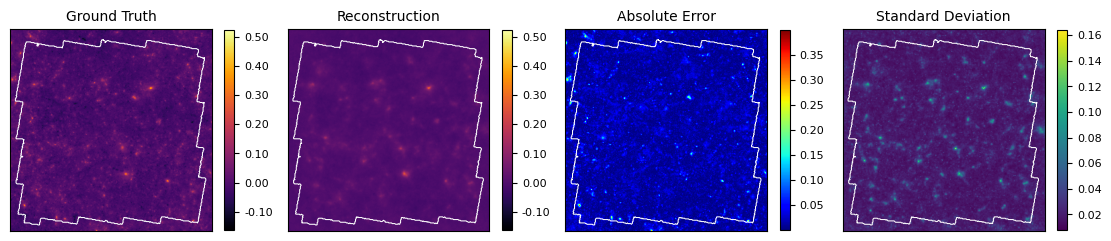

In [66]:
#FIG 0.5: Gt, recon, error, std

contours = find_contours(mask, 0.5)
outer_contour = max(contours, key=lambda x: x.shape[0])


fig, axes = plt.subplots(1, 4, figsize=(14, 4))
for axis in axes.flatten():
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

vmin = np.min(np_gts[map].real)
vmax = np.max(np_gts[map].real)

im1 = axes[0].imshow(np_gts[map].real, cmap='inferno', vmin = vmin, vmax = vmax, origin='lower')
axes[0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[0].set_title('Ground Truth')

im2 = axes[1].imshow(np_avgs[map].real, cmap='inferno', vmin = vmin, vmax = vmax, origin='lower')
axes[1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[1].set_title('Reconstruction')

im3 = axes[2].imshow(np.abs(np_avgs[map]-np_gts[map]),cmap='jet',vmin=np.min(np.abs(np_avgs[map]-np_gts[map])),
                        vmax=np.max(np.abs(np_avgs[map]-np_gts[map])),origin='lower')
axes[2].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[2].set_title('Absolute Error')

im4 = axes[3].imshow(np_stds[map].real, cmap='viridis', vmin=np.min(np_stds[map].real), vmax = np.max(np_stds[map].real), origin='lower')
axes[3].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[3].set_title('Standard Deviation')

cbar1 = fig.colorbar(im1, ax=axes[0],format=tkr.FormatStrFormatter('%.2f'), shrink=.65)
cbar2 = fig.colorbar(im2, ax=axes[1],format=tkr.FormatStrFormatter('%.2f'), shrink=.65)
cbar3 = fig.colorbar(im3, ax=axes[2],format=tkr.FormatStrFormatter('%.2f'), shrink=.65)
cbar4 = fig.colorbar(im4, ax=axes[3],format=tkr.FormatStrFormatter('%.2f'), shrink=.65)
plt.subplots_adjust(wspace=0.1, hspace=.2)


#plt.savefig(f'/share/gpu0/jjwhit/plots/new/overview_long_{fig_count}.png', bbox_inches='tight', dpi=300)
plt.show()

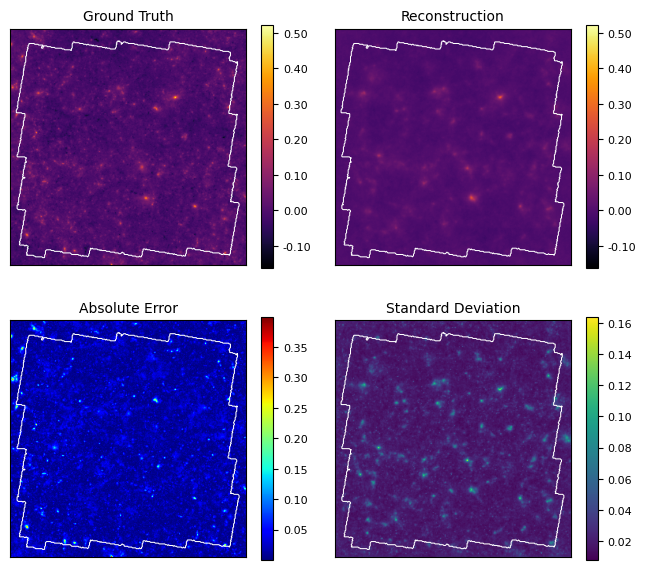

In [32]:
#FIG 1: Gt, recon, error, std

fig, axes = plt.subplots(2,2, figsize=(8,8))
for axis in axes.flatten():
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

vmin = np.min(np_gts[map].real)
vmax = np.max(np_gts[map].real)

im1 = axes[0,0].imshow(np_gts[map].real, cmap='inferno', vmin = vmin, vmax = vmax, origin='lower')
axes[0,0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[0,0].set_title('Ground Truth')

im2 = axes[0,1].imshow(np_avgs[map].real, cmap='inferno', vmin = vmin, vmax = vmax, origin='lower')
axes[0,1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[0,1].set_title('Reconstruction')

im3 = axes[1,0].imshow(np.abs(np_avgs[map]-np_gts[map]),cmap='jet',vmin=np.min(np.abs(np_avgs[map]-np_gts[map])),
                        vmax=np.max(np.abs(np_avgs[map]-np_gts[map])),origin='lower')
axes[1,0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[1,0].set_title('Absolute Error')

im4 = axes[1,1].imshow(np_stds[map].real, cmap='viridis', vmin=np.min(np_stds[map].real), vmax = np.max(np_stds[map].real), origin='lower')
axes[1,1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[1,1].set_title('Standard Deviation')

cbar1 = fig.colorbar(im1, ax=axes[0,0],format=tkr.FormatStrFormatter('%.2f'), shrink=0.75)
cbar2 = fig.colorbar(im2, ax=axes[0,1],format=tkr.FormatStrFormatter('%.2f'), shrink=0.75)
cbar3 = fig.colorbar(im3, ax=axes[1,0],format=tkr.FormatStrFormatter('%.2f'), shrink=0.75)
cbar4 = fig.colorbar(im4, ax=axes[1,1],format=tkr.FormatStrFormatter('%.2f'), shrink=0.75)
plt.subplots_adjust(wspace=0.1, hspace=-0.1)


#plt.savefig(f'/share/gpu0/jjwhit/plots/new/overview_{fig_count}.png', bbox_inches='tight', dpi=300)
plt.show()

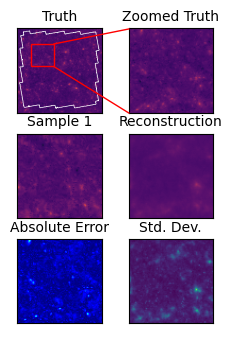

In [51]:
# Plot 2: Truth; zoomed truth, sample, reconstruction, error and std dev.
nrow = 4
ncol = 2

fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                    wspace=0.25, hspace=0.25,
                    top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                    left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))

ax = plt.subplot(gs[0, 0])
ax.imshow(np_gts[map].real, cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Truth')

ax1 = ax
rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
                        edgecolor='r',
                        facecolor='none')

ax.add_patch(rect)

ax = plt.subplot(gs[0, 1])
ax.imshow(np_gts[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
        cmap='inferno',
        vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Zoomed Truth')

connection_path_1 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty],
                                            [0, 0], coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_1)
connection_path_2 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty + zoom_length], [0, zoom_length],
                                            coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_2)

for samp in range(1):
    ax = plt.subplot(gs[1, samp])
    ax.imshow(np_samps[map][samp][zoom_starty:zoom_starty + zoom_length,
                zoom_startx:zoom_startx + zoom_length].real, cmap='inferno', 
                vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Sample {samp + 1}')

ax = plt.subplot(gs[1, 1])
ax.imshow(
    np_avgs[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Reconstruction')

ax = plt.subplot(gs[2, 0])
ax.imshow(np.abs(np_avgs[map][zoom_starty:zoom_starty + zoom_length,    
            zoom_startx:zoom_startx + zoom_length] - np_gts[map][zoom_starty:zoom_starty + zoom_length,
            zoom_startx:zoom_startx + zoom_length]), cmap='jet', vmin=np.min(np.abs(np_avgs[map] - np_gts[map])),
                vmax=np.max(np.abs(np_avgs[map] - np_gts[map])))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Absolute Error")

ax = plt.subplot(gs[2, 1])
ax.imshow(np_stds[map][zoom_starty:zoom_starty + zoom_length,
            zoom_startx:zoom_startx + zoom_length].real, cmap='viridis', vmin=np.min(np_stds[map].real),
            vmax=np.max(np_stds[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Std. Dev.')

#plt.savefig(f'/share/gpu0/jjwhit/plots/new/zoomed_overview{fig_count}.png', bbox_inches='tight', dpi=300)
plt.show()

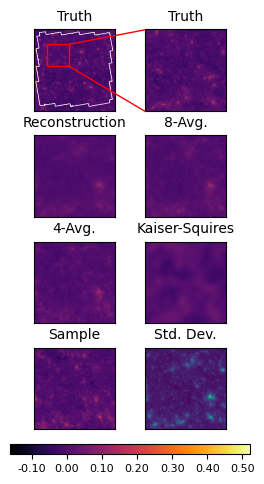

In [53]:
#Plot 3: truth; zoomed truth, reconstruction, 8-, 4-, 2-avg, sample, std. dev.

nrow = 4
ncol = 2

fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                        wspace=0.25, hspace=0.3,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))

ax = plt.subplot(gs[0, 0])
ax.imshow(np_gts[map].real, cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
plt.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Truth')

ax1 = ax
rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
                            edgecolor='r',
                            facecolor='none')

ax.add_patch(rect)
ax = plt.subplot(gs[0, 1])
im = ax.imshow(np_gts[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
            cmap='inferno',
            vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Truth')

connection_path_1 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty],
                                            [0, 0], coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_1)
connection_path_2 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty + zoom_length], [0, zoom_length],
                                            coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_2)

ax = plt.subplot(gs[1, 0])
ax.imshow(
    np_avgs[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Reconstruction')

ax = plt.subplot(gs[1, 1])
avg = np.zeros((cfg.im_size, cfg.im_size), dtype=np.complex128)
for l in range(8):
    avg += np_samps[map][l]
avg = avg / 8

ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([]) 
ax.set_title('8-Avg.')


ax = plt.subplot(gs[2, 0])
avg = np.zeros((cfg.im_size, cfg.im_size), dtype=np.complex128)
for l in range(4):
    avg += np_samps[map][l]

avg = avg / 4
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('4-Avg.')


ax = plt.subplot(gs[2, 1])
avg = np.zeros((cfg.im_size, cfg.im_size), dtype=np.complex128)
for l in range(2):
    avg += np_samps[map][l]


kernel = MMDataTransform.compute_fourier_kernel(cfg.im_size)
gamma_sim = MMDataTransform.forward_model(np_gts[map], kernel) + (
            std1 * np.random.randn(cfg.im_size, cfg.im_size) + 1.j * std2 * np.random.randn(cfg.im_size, cfg.im_size)
        )
backward = backward_model(gamma_sim, kernel)
ks = ndimage.gaussian_filter(backward, sigma=1/.29)

ax.imshow(
    ks[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Kaiser-Squires')


for samp in range(1):
    ax = plt.subplot(gs[3, 0])
    ax.imshow(np_samps[map][samp][zoom_starty:zoom_starty + zoom_length,
                zoom_startx:zoom_startx + zoom_length].real, cmap='inferno', 
                vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Sample')

ax = plt.subplot(gs[3, 1])
ax.imshow(np_stds[map][zoom_starty:zoom_starty + zoom_length,
            zoom_startx:zoom_startx + zoom_length].real, cmap='viridis', vmin=np.min(np_stds[map].real),
            vmax=np.max(np_stds[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Std. Dev.') 

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8,format=tkr.FormatStrFormatter('%.2f'))

#plt.savefig(f'/share/gpu0/jjwhit/plots/new/zoomed_aes_{fig_count}.png', bbox_inches='tight', dpi=300)
plt.show()

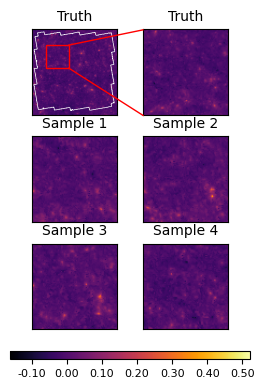

In [55]:
#Plot 4: Zoomed diversity.
nrow = 3
ncol = 2
fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                        wspace=0.25, hspace=0.25,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))

ax = plt.subplot(gs[0, 0])
im = ax.imshow(np_gts[map].real, cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
plt.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Truth')

ax1 = ax
rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
                            edgecolor='r',
                            facecolor='none')

ax.add_patch(rect)

ax = plt.subplot(gs[0, 1])
ax.imshow(np_gts[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
            cmap='inferno',
            vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Truth')

connection_path_1 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty],
                                            [0, 0], coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_1)
connection_path_2 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty + zoom_length], [0, zoom_length],
                                            coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_2)

for samp in range(2):
    ax = plt.subplot(gs[1, samp])
    ax.imshow(np_samps[map][samp][zoom_starty:zoom_starty + zoom_length,
            zoom_startx:zoom_startx + zoom_length].real, cmap='inferno',
                vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Sample {samp + 1}')

for samp in range(2):
    ax = plt.subplot(gs[2, samp])
    ax.imshow(np_samps[map][samp+2][zoom_starty:zoom_starty + zoom_length,
            zoom_startx:zoom_startx + zoom_length].real, cmap='inferno',
                vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Sample {samp + 3}')

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8,format=tkr.FormatStrFormatter('%.2f'))



#plt.savefig(f'/share/gpu0/jjwhit/plots/new/diversity_{fig_count}.png', bbox_inches='tight', dpi=300)
plt.show()

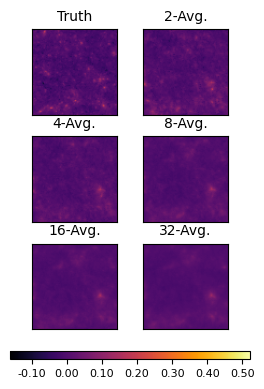

In [56]:
# #Plot 5: zoomed P-ascent.
nrow = 3
ncol = 2
fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                        wspace=0.25, hspace=0.25,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))


ax = plt.subplot(gs[0, 0])
im = ax.imshow(np_gts[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
            cmap='inferno',
            vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Truth')

ax1 = ax
ax = plt.subplot(gs[0, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(2):
    avg += np_samps[map][l]

avg = avg / 2
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('2-Avg.')


ax = plt.subplot(gs[1, 0])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(4):
    avg += np_samps[map][l]

avg = avg / 4
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('4-Avg.')


ax = plt.subplot(gs[1, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(8):
    avg += np_samps[map][l]

avg = avg / 8
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('8-Avg.')


ax = plt.subplot(gs[2, 0])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(16):
    avg += np_samps[map][l]

avg = avg / 16
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('16-Avg.')

ax = plt.subplot(gs[2, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(32):
    avg += np_samps[map][l]

avg = avg / 32
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('32-Avg.')

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8,format=tkr.FormatStrFormatter('%.2f'))


#plt.savefig(f'/share/gpu0/jjwhit/plots/new/zoom_P_ascent_{fig_count}.png', bbox_inches='tight', dpi=300)
plt.show()

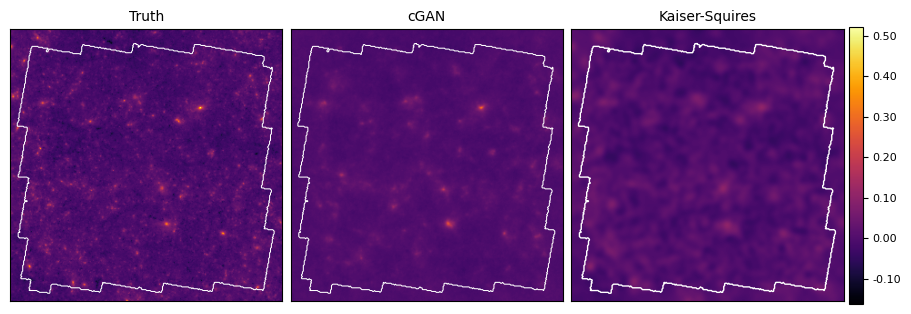

In [61]:
#Plot 6: Kaiser Squires comparison
kernel = MMDataTransform.compute_fourier_kernel(cfg.im_size)
gamma_sim = MMDataTransform.forward_model(np_gts[map], kernel) + (
            std1 * np.random.randn(cfg.im_size, cfg.im_size) + 1.j * std2 * np.random.randn(cfg.im_size, cfg.im_size)
        )
backward = backward_model(gamma_sim, kernel)
ks = ndimage.gaussian_filter(backward, sigma=1/.29)

nrow = 1
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(9,3), constrained_layout=True)

for axis in axes.flatten():
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


vmin = np.min(np_gts[map].real)
vmax = np.max(np_gts[map].real)

im1 = axes[0].imshow(np_gts[map].real, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
axes[0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=0.75)
axes[0].set_title('Truth')

im2 = axes[1].imshow(np_avgs[map].real, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
axes[1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=0.75)
axes[1].set_title('cGAN')

im4 = axes[2].imshow(ks.real, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
axes[2].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=1)
axes[2].set_title('Kaiser-Squires')

cbar4 = fig.colorbar(im4, ax=axes[2], orientation='vertical', pad=0.02,format=tkr.FormatStrFormatter('%.2f'))
cbar4.mappable.set_clim(vmin, vmax)

#plt.savefig(f'/share/gpu0/jjwhit/plots/new/ks_comp_{fig_count}.png', bbox_inches='tight', dpi=300)
plt.show()

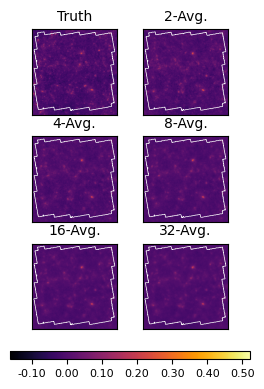

In [62]:
#Plot 7: P-ascent.
nrow = 3
ncol = 2
fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                        wspace=0.25, hspace=0.25,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))


ax = plt.subplot(gs[0, 0])
im = ax.imshow(np_gts[map].real, cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Truth')

ax1 = ax

ax = plt.subplot(gs[0, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(2):
    avg += np_samps[map][l]

avg = avg / 2
ax.imshow(avg.real,cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('2-Avg.')


ax = plt.subplot(gs[1, 0])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(4):
    avg += np_samps[map][l]

avg = avg / 4
ax.imshow(avg.real, cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('4-Avg.')


ax = plt.subplot(gs[1, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(8):
    avg += np_samps[map][l]

avg = avg / 8
ax.imshow(avg.real, cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('8-Avg.')


ax = plt.subplot(gs[2, 0])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(16):
    avg += np_samps[map][l]

avg = avg / 16
ax.imshow(avg.real, cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('16-Avg.')

ax = plt.subplot(gs[2, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(32):
    avg += np_samps[map][l]

avg = avg / 32
ax.imshow(avg.real, cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('32-Avg.')

cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8,format=tkr.FormatStrFormatter('%.2f'))


#plt.savefig(f'/share/gpu0/jjwhit/plots/new/P_ascent_{fig_count}.png', bbox_inches='tight', dpi=300)
plt.show()

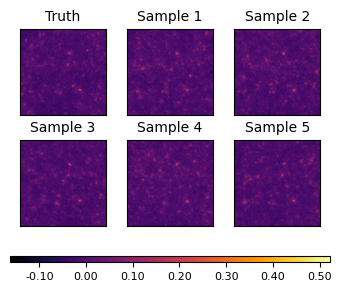

In [64]:
# Plot 8: Posterior samples.
nrow = 2
ncol = 3
fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                        wspace=0.25, hspace=0.25,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))


ax = plt.subplot(gs[0, 0])
im = ax.imshow(np_gts[map].real, cmap='inferno', vmin=vmin, vmax=vmax)
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Truth')

ax1 = ax

for samp in range(2):
    ax = plt.subplot(gs[0, samp+1])
    ax.imshow(np_samps[map][samp].real, cmap='inferno', 
                vmin=vmin, vmax=vmax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Sample {samp + 1}')

for samp in range(3):
    ax = plt.subplot(gs[1, samp])
    ax.imshow(np_samps[map][samp+3].real, cmap='inferno', 
                vmin=vmin, vmax=vmax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Sample {samp + 3}')


cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8,format=tkr.FormatStrFormatter('%.2f'))


#plt.savefig(f'/share/gpu0/jjwhit/plots/new/samples_new_{fig_count}.png', bbox_inches='tight', dpi=300)
plt.show()

In [34]:
# Compute correlation function

abs_flat = np_avgs['10'].flatten()
std_flat = np_stds['10'].flatten()

r, p = pearsonr(abs_flat.real, std_flat.real)

In [35]:
r

0.7309713926299826

In [43]:
#Plot p-val vs PSNR
psnr_vals = []
for p in range(1, 33):
    avg_img = np.mean(np_samps[map][:p].real, axis=0) #same as how we make recon
    psnr_instance = psnr(np_gts[map]s[map].real, avg_img)
    psnr_vals.append(psnr_instance)

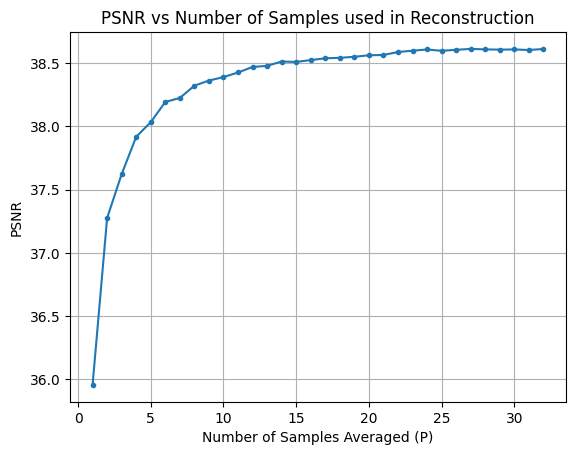

In [57]:
p_values = range(1, 33)
plt.plot(p_values, psnr_vals, marker='.')
plt.xlabel('Number of Samples Averaged (P)')
plt.ylabel('PSNR')
plt.title('PSNR vs Number of Samples used in Reconstruction')
plt.grid(True)
#plt.show()
plt.savefig('/share/gpu0/jjwhit/plots/final/p_vs_psnr.png',bbox_inches='tight', dpi=300)